<a href="https://colab.research.google.com/github/keshavramaswamy/ipython-notebooks/blob/master/quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('train.csv')

In [0]:
from tqdm import tqdm
tqdm.pandas()

In [0]:
from fastai.text import *

In [0]:
def clean_text(x):

    x = str(x)
    
    for punct in "/-'":
        x = x.replace(punct, ' ')
        
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
        
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
        
    return x

In [0]:
def replace_text(x):

    x = str(x)
    
    x = x.replace('endeavoured', 'aimed')
    
    x = x.replace('daown', 'down')
    
    x = x.replace('abaout', 'about')
        
    return x

In [8]:
df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [9]:
bs = 48
data_lm = (TextList.from_csv('.', 'train.csv', cols='question_text')
                .split_by_rand_pct(valid_pct=0.1, seed=0)
                .label_for_lm()
                .databunch(bs=bs))

In [10]:
data_lm.show_batch()

idx,text
0,"i convert montra xxunk d to a mountain bike by just changing the tyres ? xxbos xxmaj is xxmaj gaza slowly becoming xxmaj auschwitz , xxmaj dachau or xxmaj xxunk for xxmaj palestinians ? xxbos xxmaj why does xxmaj quora automatically ban conservative opinions when reported , but does not do the same for liberal views ? xxbos xxmaj is there such a thing as dressing moderately , and if"
1,what is the maximum number of motors i can run with one xxup xxunk ? xxbos xxmaj will there ever be respect between the political parties here in the xxup us or are we on a downward spiral ? xxbos xxmaj is there any truth to the xxmaj radio xxmaj free xxmaj asia article that says the xxmaj chinese government is forcing xxmaj muslims in xxmaj xinjiang to hand in
2,rational about politics if we try hard enough ? xxbos i have a hard time making friends . i believe because my mother taught me that people are deceitful . i 'm 27 now and find it harder to make friends . xxmaj how do i make friends ? xxbos xxmaj shall we ban fully semi - automatic assault knives ? xxbos xxup isis xxmaj israels xxmaj creation ? xxbos
3,"different from those in xxmaj india ? xxbos xxmaj when a government is unable / unwilling to protect its citizens from criminality , is vigilantism justifiable ? xxbos xxmaj where can i find the most unbiased news about xxmaj syria 's current state of affairs ? xxbos xxmaj how do i ask out a girl who teaches me piano ? xxbos xxmaj how did xxmaj jack xxmaj ma start xxmaj"
4,arabia ? xxbos xxmaj do venomous snakes have the ability to constrict their prey ? xxbos xxmaj what would be the best career option for a maths graduate ? xxbos xxmaj why do they have xxmaj quiet mostly shirtless throughout the game of xxmaj metal xxmaj gear xxmaj solid v ? xxbos xxmaj at what temperature semiconductor start conducting ? xxbos xxmaj how would you recommend i turn my isometric


In [0]:
data_lm.save('tmp_lm.pkl')

In [12]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


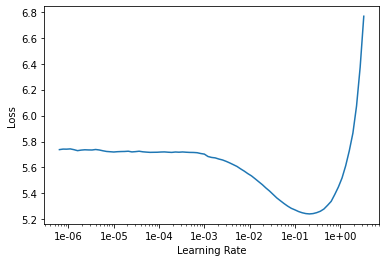

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,3.684588,3.553767,0.383546,18:23


In [0]:
learn.save('lm1')

In [0]:
learn.load('lm1');

In [0]:
learn.unfreeze()

In [19]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


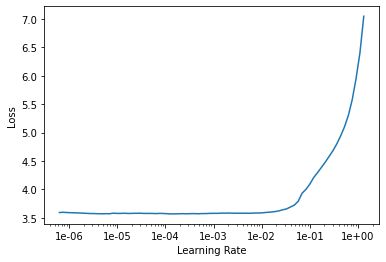

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.377060,3.322542,0.408722,20:43
1,3.244386,3.255612,0.416687,20:43


In [0]:
learn.save_encoder('fine_tuned_enc')

In [23]:
data_class = (TextList.from_csv('.', 'train.csv', cols='question_text')
                .split_by_rand_pct(valid_pct=0.1, seed=0)
                .label_from_df(cols=2)
                .databunch(bs=bs))
data_class.save('tmp_clas')

In [24]:
data_class.show_batch()

text,target
xxbos xxmaj what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty } \ underbrace { \ xxunk } } _ { \ xxunk 's xxmaj law of xxmaj theoretical xxmaj probability .,1
"xxbos xxmaj will she come back ? xxmaj she was my best friend and i fell in love with her and she got to know about it and she left me . xxmaj she was dating someone else at that time . xxmaj it 's been 2 years and i still miss her , i even get happy dreams about her . xxmaj what do i do ?",0
"xxbos xxmaj who would win , xxmaj black xxmaj adam , xxmaj general xxmaj zod , xxmaj bane , xxmaj harley xxmaj quinn , xxmaj parasite , xxmaj gorilla xxmaj grodd , xxmaj poison xxmaj ivy and xxmaj xxunk xxmaj ra vs xxmaj superman , xxmaj cyborg , xxmaj wonder xxmaj woman , xxmaj batman , xxmaj booster xxmaj gold as the xxmaj justice xxmaj league ?",0
"xxbos xxmaj why in xxmaj southeast xxmaj asia , xxmaj singapore 's port is dominating ? xxmaj why do n't the cargo ships just directly go to the biggest market in the area , such as to a port in mainland xxmaj southeast xxmaj asia or to xxmaj jawa island ? xxmaj why they need to stop by in xxmaj singapore first ?",0
"xxbos xxmaj does xxmaj reach ’s gravity play a big role in the training and strength of the xxmaj spartan iis and xxunk ? xxmaj like , because xxmaj reach has denser gravity ( if xxmaj reach does ) , would the xxmaj spartan iis and iis be weaker if trained on xxmaj earth , or would still be just as strong ?",0


In [0]:
learn = text_classifier_learner(data_class, drop_mult=0.5, arch=AWD_LSTM)

In [0]:
learn.load_encoder('fine_tuned_enc');

In [0]:
learn.freeze()

In [28]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


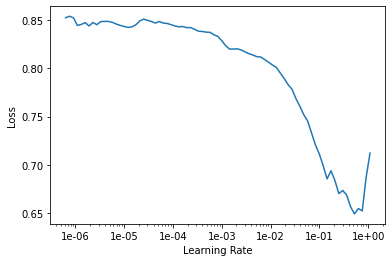

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.127814,0.122550,0.952462,06:51


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


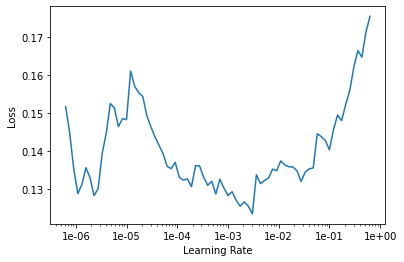

In [34]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(1, slice((1e-3/2)/(2.6**4),(1e-3/2)), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.112085,0.109050,0.957584,08:33


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


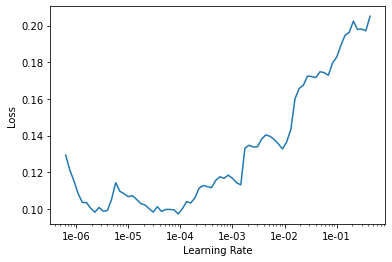

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(1, 1e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.121392,0.106538,0.959054,18:54


In [0]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(df.question_text,df.target,  
                              train_size=0.9, random_state=0)

In [51]:
val_x

879280     Whether advances from customers are to be rein...
43285                                  How can you get help?
740986     How does one succeed as a lecturer in medicine...
472594      What is the purpose behind the Yellow wallpaper?
453814     What is the problem by applying under non spp ...
                                 ...                        
1029649    What annual increments are given to employees ...
1006882    Can a 11kV ring type metering CT be used for 3...
883498           What are the best Macbook Pro alternatives?
1033859    What went wrong for Gerard Houllier as manager...
46693      How do I get admission in University of Toront...
Name: question_text, Length: 130613, dtype: object

In [0]:
learn.save('model')

In [0]:
preds = learn.predict(val_x[:5])

In [58]:
preds

(Category tensor(0), tensor(0), tensor([9.9993e-01, 7.0812e-05]))

In [59]:
len(preds)

3

In [0]:
val_x = pd.DataFrame(val_x)
val_x.columns = ['question_text']

In [72]:
val_x.iloc[0].loc['question_text']

'Whether advances from customers are to be reinstated in the financial statements?'

In [84]:
learn.predict(val_x.iloc[0].loc['question_text'])[2][1].numpy()

array(0.000962, dtype=float32)

In [85]:
val_x

,question_text
879280,Whether advances from customers are to be rein...
43285,How can you get help?
740986,How does one succeed as a lecturer in medicine...
472594,What is the purpose behind the Yellow wallpaper?
453814,What is the problem by applying under non spp ...
...,...
1029649,What annual increments are given to employees ...
1006882,Can a 11kV ring type metering CT be used for 3...
883498,What are the best Macbook Pro alternatives?
1033859,What went wrong for Gerard Houllier as manager...


In [0]:
val_x['target'] = val_y

In [87]:
val_x

,question_text,target
879280,Whether advances from customers are to be rein...,0
43285,How can you get help?,0
740986,How does one succeed as a lecturer in medicine...,0
472594,What is the purpose behind the Yellow wallpaper?,0
453814,What is the problem by applying under non spp ...,0
...,...,...
1029649,What annual increments are given to employees ...,0
1006882,Can a 11kV ring type metering CT be used for 3...,0
883498,What are the best Macbook Pro alternatives?,0
1033859,What went wrong for Gerard Houllier as manager...,0


In [88]:
preds = []

for i, text in enumerate(list(val_x.question_text)):

  print(f"{(i+1)*100/len(val_x)}% done")

  pred = learn.predict(text)[2][1].numpy()

  preds.append(pred)

Streaming output truncated to the last 5000 lines.
3.735462779355807% done
3.736228399929563% done
3.7369940205033187% done
3.737759641077075% done
3.738525261650831% done
3.739290882224587% done
3.740056502798343% done
3.7408221233720993% done
3.741587743945855% done
3.7423533645196114% done
3.7431189850933673% done
3.7438846056671236% done
3.7446502262408794% done
3.7454158468146357% done
3.7461814673883915% done
3.746947087962148% done
3.7477127085359037% done
3.74847832910966% done
3.749243949683416% done
3.750009570257172% done
3.750775190830928% done
3.751540811404684% done
3.75230643197844% done
3.7530720525521963% done
3.753837673125952% done
3.7546032936997085% done
3.7553689142734643% done
3.7561345348472206% done
3.7569001554209764% done
3.7576657759947327% done
3.7584313965684886% done
3.759197017142245% done
3.7599626377160007% done
3.7607282582897565% done
3.761493878863513% done
3.7622594994372687% done
3.763025120011025% done
3.763790740584781% done
3.764556361158537% d

KeyboardInterrupt: ignored

In [121]:
len(learn.data.train_ds)

1175510

In [122]:
len(learn.data.valid_ds)

130612

In [120]:
preds = learn.get_preds()

In [127]:
preds[0]

tensor([[9.9905e-01, 9.4506e-04],
        [9.9366e-01, 6.3360e-03],
        [9.9834e-01, 1.6620e-03],
        ...,
        [9.9311e-01, 6.8930e-03],
        [9.9869e-01, 1.3107e-03],
        [9.9858e-01, 1.4157e-03]])

In [131]:
preds[0][:, 1]

tensor([0.0009, 0.0063, 0.0017,  ..., 0.0069, 0.0013, 0.0014])

In [0]:
probs = preds[0][:, 1]

In [159]:
learn.data.valid_ds.y

CategoryList (130612 items)
0,0,0,0,0
Path: .

In [0]:
ytrue = []
for i in learn.data.valid_ds.y:
  ytrue.append(int(i))

In [171]:
len(ytrue)

130612

In [172]:
len(probs)

130612

In [0]:
from sklearn.metrics import f1_score, accuracy_score

In [0]:
import sklearn

In [176]:
probs

tensor([0.0009, 0.0063, 0.0017,  ..., 0.0069, 0.0013, 0.0014])

In [189]:
for thresh in np.arange(0., 1., 0.1):
  thresh = np.round(thresh, 2)
  pred_probs = [1 if p >= thresh else 0 for p in probs]
  fscore = f1_score(ytrue, pred_probs, average='macro')
  acc = accuracy_score(ytrue, pred_probs)
  print(thresh, fscore, acc)

0.0 0.05723215510209974 0.06070652007472514
0.1 0.7633383302414745 0.9200073500137813
0.2 0.8005952418132904 0.9437111444583959
0.3 0.8138273294011888 0.9534116313968088
0.4 0.8126761670068816 0.9578216396655743
0.5 0.7976383697917806 0.9590542982268092
0.6 0.7591058971698239 0.956688512540961
0.7 0.6955728988912386 0.952301473065262
0.8 0.5985366194623383 0.9458242734205127
0.9 0.508696620543716 0.9405644198082871
